# Overview
By now you should have already familiarized yourself with the Yelp data. In this task, you will work on mining this data set to discover knowledge about cuisines. In the Yelp dataset, businesses are tagged with categories. For example, the category "restaurant" identifies all the restaurants. Specific restaurants are also tagged with cuisines (e.g., "Indian" or "Italian"). This provides an opportunity to aggregate all the information about a particular cuisine and obtain an enriched representation of a cuisine using, for example, review text for all the restaurants of a particular cuisine. Such a representation can then be exploited to assess the similarity between two cuisines, which further enables clustering of cuisines.

The goal of this task is to mine the data set to construct a cuisine map to visually understand the landscape of different types of cuisines and their similarities. The cuisine map can help users understand what cuisines are available and their relations, which allows for the discovery of new cuisines, thus facilitating exploration of unfamiliar cuisines. You can see a sample set of reviews from all the restaurants for a cuisine, but you are strongly encouraged to experiment with your own set of cuisines if you have time.

# Instructions
Some questions to consider when building the cuisine map are the following:

1. What's the best way of representing a cuisine? If all we know about a cuisine is just the name, then there is nothing we can do. However, if we can associate a cuisine with the restaurants offering the cuisine and all the information about the restaurants, particularly reviews, then we will have a basis to characterize cuisines and assess their similarity. Since review text contains a lot of useful information about a cuisine, a natural question is: what's the best way to represent a cuisine with review text data? 2. Are some words more important in representing a cuisine than others?
What's the best way of computing the similarity of two cuisines? Assuming that two cuisines can each be represented by their corresponding reviews, how should we compute their similarity?
3. What's the best way of clustering cuisines? Clustering of cuisines can help reveal major categories of cuisines. How would the number of clusters impact the utility of your results for understanding cuisine categories? How does a clustering algorithm affect the visualization of the cuisine map?
4. Is your cuisine map actually useful to at least some people? In what way? If it's not useful, how might you be able to improve it to make it more useful?

In [162]:
import math
import json
import pickle
import random
import logging
import glob
import argparse
import os
import warnings

import pandas as pd
import numpy as np

from gensim import models
from gensim import matutils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, Birch, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

from time import time
from nltk.tokenize import sent_tokenize
from pathlib2 import Path
from nltk.corpus import stopwords
from collections import Counter, OrderedDict
STOP_WORDS = stopwords.words('english')


from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
cluster_colors = {-1:'black', 0:'gold', 1:'blue', 2:'green', 3:'red', 4:'saddlebrown', 5:'darkviolet', 
            6:'yellow', 7:'pink', 8:'orange', 9:'firebrick', 10:'deepskyblue',
            11:'aqua', 12:'saddlebrown', 13:'springgreen', 14:'dodgerblue', 15:'coral',
            16:'mediumslateblue', 17:'magenta', 18:'seagreen', 19:'lightslategrey', 20:'cyan'}




pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Preprocessing
1. I experimented with running `py27_processYelpRestaurants.py` several times, but ultimately used the categories provided and narrowed down my cuisine selection based on the top 50 categories with the most reviews.  

2. I performed preprocessing via sklearn's TfidfVectorizer and focus on some of the following parameters:  
    * remove stop words using nltk
    * decoding to utf8 and removing accents
    * convert all words to lowercase
    * min_df=n (ignore terms that occur fewer than n times)
    * max_df (ignore terms that have a higher document frequency than the threshold selected)
    * max_features=10000 (only consider the top max_features based on term frequency)
    * use_idf (don't inverse document frequency for intial tax)


In [2]:
%%time
N=50
# allpaths = glob.glob('../data/categories/*')
allfiles = os.listdir('../data/categories/')
review_counter = {}

for f in allfiles:
    cuisine = f
    count = len(open(Path('../data/categories/' + f)).readlines(  ))
    review_counter.update({cuisine: count})
review_counter = Counter(review_counter)  
topN_cuisines = list(OrderedDict(review_counter.most_common(N)).keys())

CPU times: user 909 ms, sys: 223 ms, total: 1.13 s
Wall time: 1.18 s


In [3]:
%%time
allfiles = os.listdir('../data/categories/')
cuisines = [f.replace('.txt','') for f in topN_cuisines]
contents = [Path('../data/categories/' + f)\
                .read_text(encoding="utf8")\
                .replace('\n',' ')\
            for f in topN_cuisines]

CPU times: user 1.43 s, sys: 526 ms, total: 1.96 s
Wall time: 1.96 s


In [4]:
def vectorizer(contents, use_idf=False, min_df=2, max_df=0.5, stop_words=STOP_WORDS):
    vectorizer = TfidfVectorizer(stop_words=stop_words, # from nltk
                                 encoding='utf-8',
                                 strip_accents='unicode',
                                 lowercase=True,
                                 use_idf=use_idf,
                                 max_features=10000,
                                 min_df=min_df, max_df=max_df)
    matrix = vectorizer.fit_transform(contents)
    id2words ={}
    for i,word in enumerate(vectorizer.get_feature_names()):
        id2words[i] = word
    return matrix, np.vstack([cosine_similarity(val, matrix)for val in matrix]), id2words

In [5]:
def draw(matrix, colormap='BuPu'):
    # https://matplotlib.org/tutorials/colors/colormaps.html
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap=colormap)
    ax.set_xticks(np.arange(matrix.shape[1]), minor=False)
    ax.set_yticks(np.arange(matrix.shape[0]), minor=False)
    ax.grid(which='major', color='blue', linestyle='-', linewidth='0.3')
    ax.set_xticklabels(matrix.index, rotation='vertical')
    ax.set_yticklabels(matrix.index)
    fig.colorbar(cax, ticks=np.linspace(0,1,11))
    fig.set_size_inches(20, 20)
    plt.show()

## Task 2.1: Visualization of the Cuisine Map

Use all the reviews of restaurants of each cuisine to represent that cuisine and compute the similarity of cuisines based on the similarity of their corresponding text representations. Visualize the similarities of the cuisines and describe your visualization.

The visualization shows the similarity matrix, with every cell corresponding to the similarity between two cuisines. The opacity of each cell is the similarity - with a higher opacity for a higher similarity.

In [6]:
%%time
matrix_if1, similarity_if1, id2words1 = vectorizer(contents, use_idf=False)

CPU times: user 1min 32s, sys: 3.19 s, total: 1min 35s
Wall time: 1min 36s


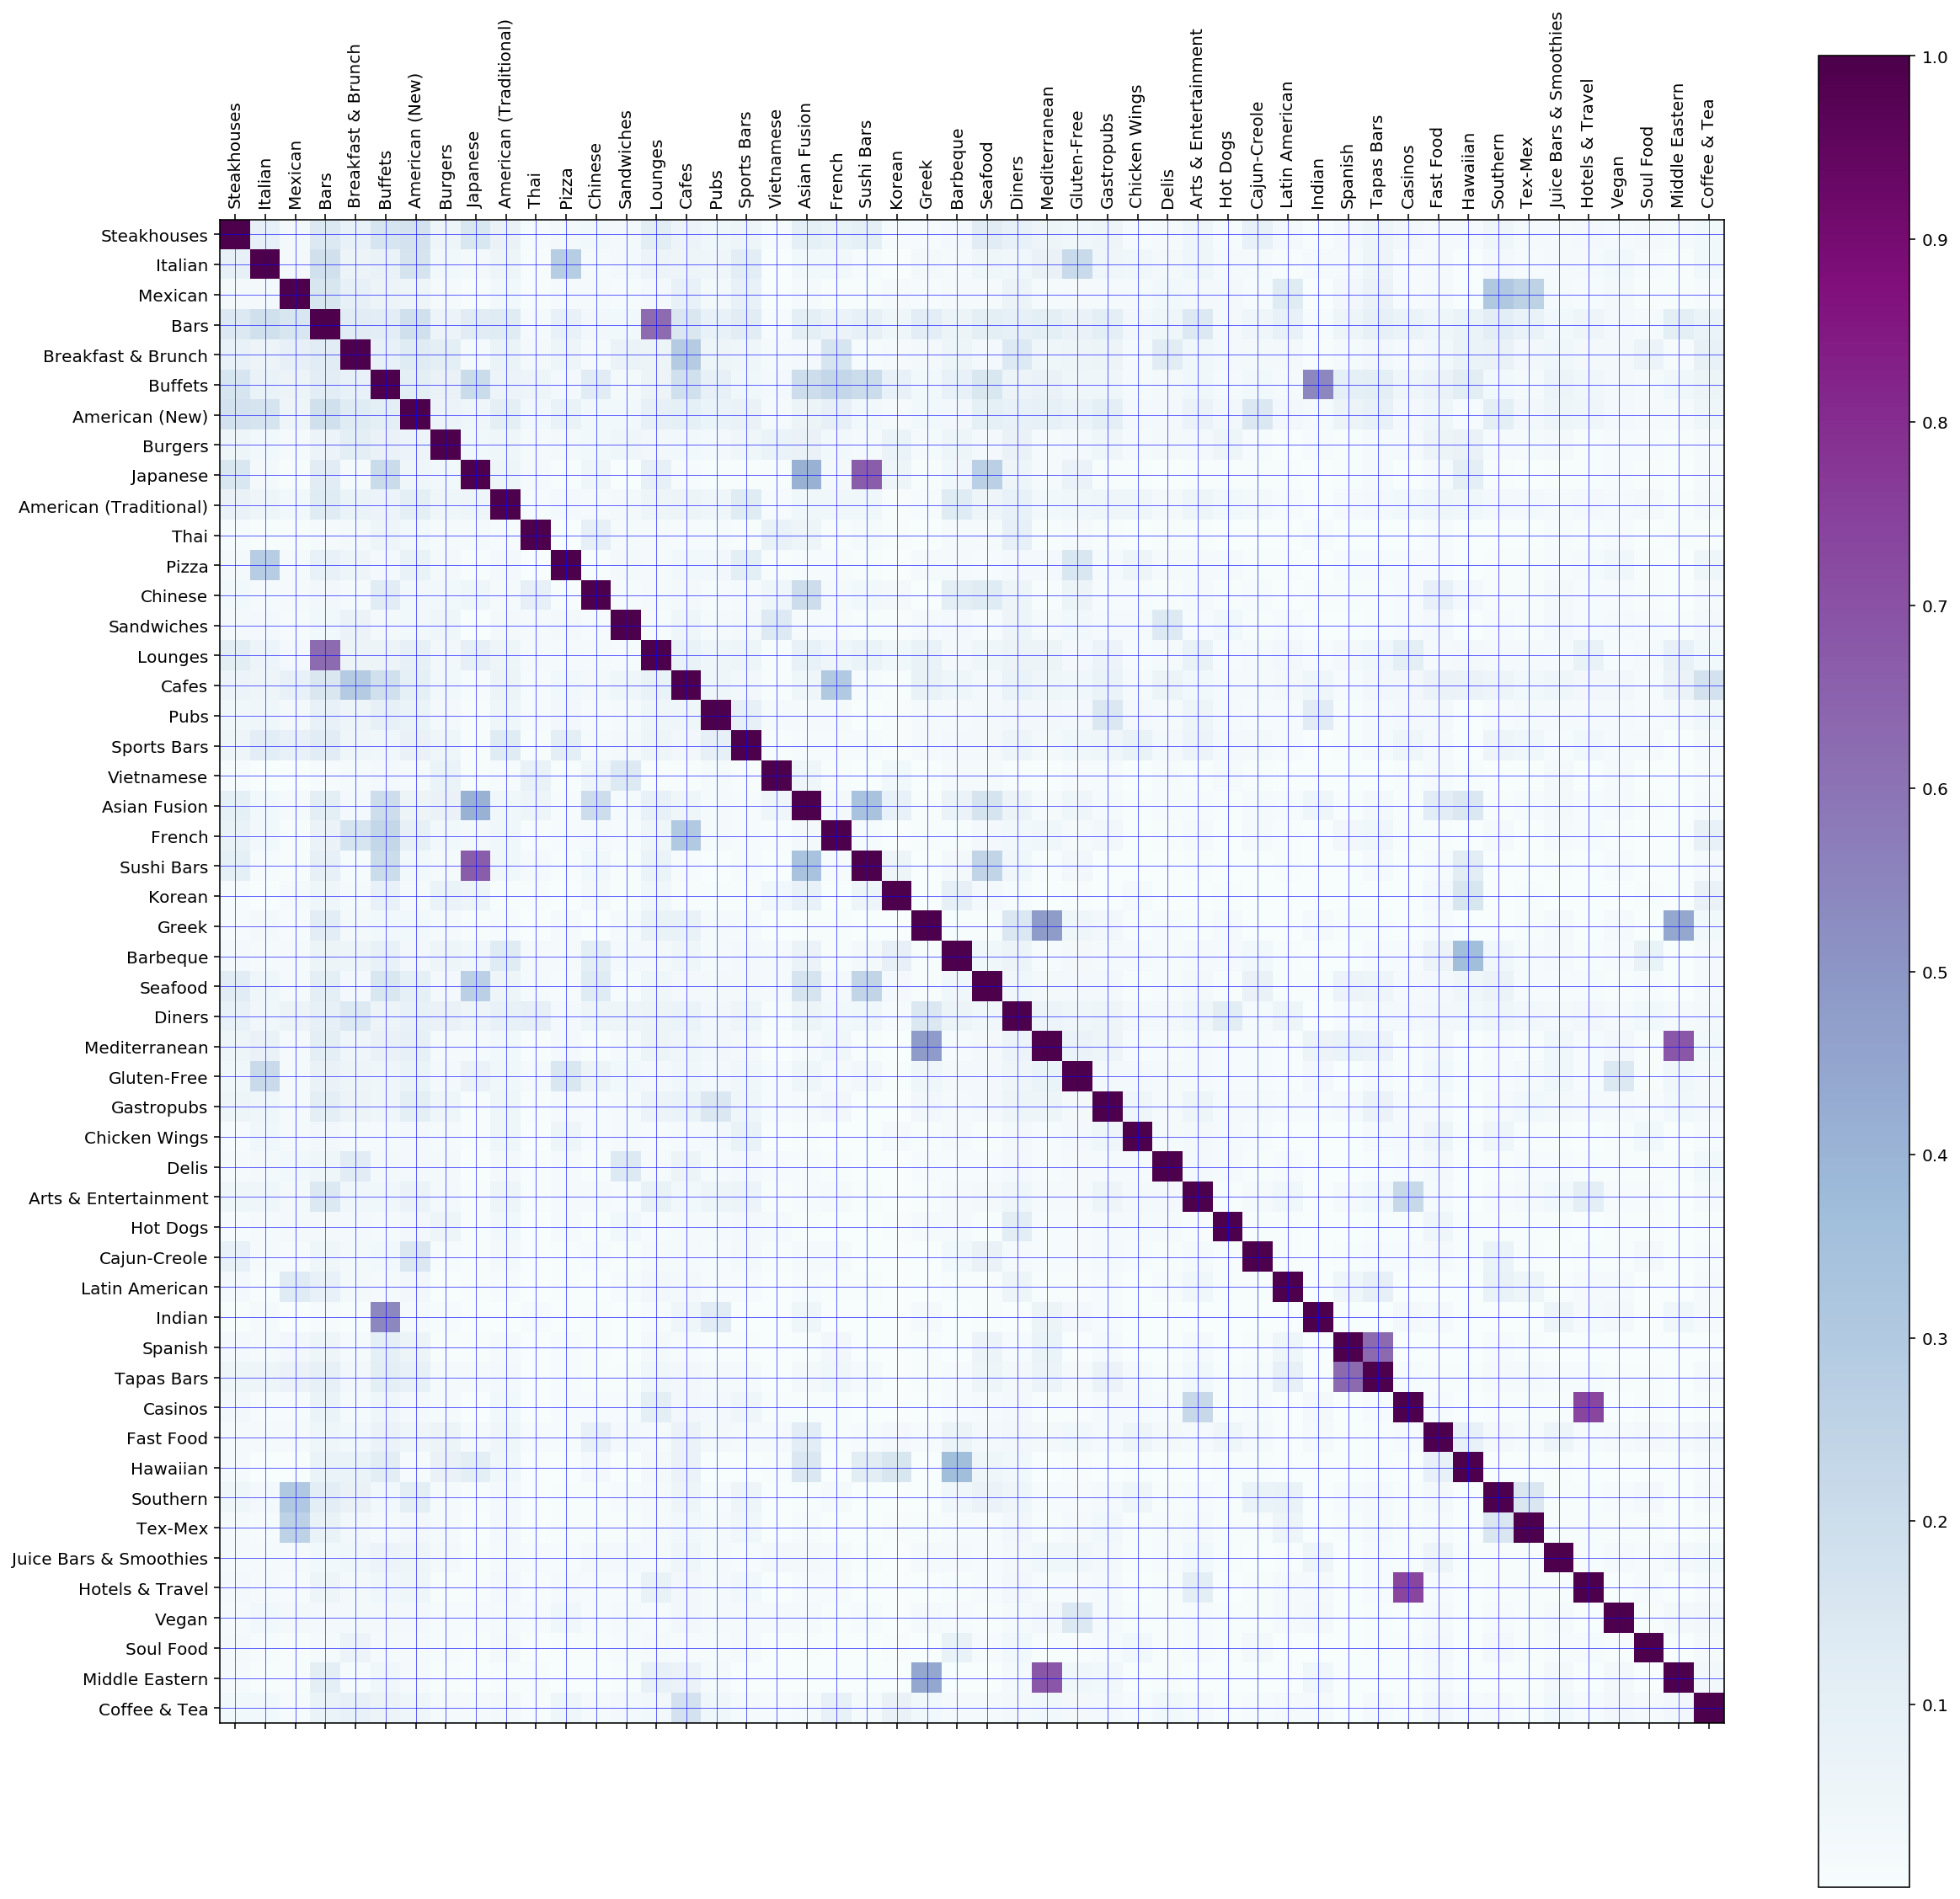

In [7]:
matrix = pd.DataFrame(similarity_if1)
matrix.columns = cuisines
matrix.index = cuisines
draw(matrix)

## Task 2.2: Improving Clustering Results

Try to improve the cuisine map by 1) varying the text representation (e.g., improving the weighting of terms or applying topic models) and 2) varying the similarity function (e.g., concatenate all reviews then compute the similarity vs. computing similarity of individual reviews and then aggregate the similarity values). Does any improvement lead to a better map?

Experiments Performed:
* use inverse-document frequency weighting
* apply LDA to mine topics; experimented with different numbers of topics

In [6]:
%%time
# matrix_if, similarity_if, id2words = vectorizer(contents, use_idf=False)
vectorizer = TfidfVectorizer(stop_words=STOP_WORDS, # from nltk
                             encoding='utf-8',
                             strip_accents='unicode',
                             lowercase=True,
                             ngram_range=(1,2),
                             use_idf=True,
                             max_features=10000,
                             min_df=0.2, max_df=0.7)
matrix = vectorizer.fit_transform(contents)

NameError: name 'id2words' is not defined

In [8]:
%%time
id2words ={}
for i,word in enumerate(vectorizer.get_feature_names()):
    id2words[i] = word
# include LDA
corpus = matutils.Sparse2Corpus(matrix, documents_columns=False)
lda = models.ldamodel.LdaModel(corpus, 
                                num_topics=50,
                                id2word=id2words,
                                alpha='auto',
                                eval_every=5) # can play around with number of topics
doc_topics = lda.get_document_topics(corpus)

topic_pro = np.zeros((len(cuisines), len(doc_topics)))
idx = 0
for val in doc_topics:
    for jdx, pro in val:
        topic_pro[idx][jdx] = pro
    idx += 1

/anaconda3/envs/uiuc/lib/python3.6/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


CPU times: user 11.4 s, sys: 95.5 ms, total: 11.5 s
Wall time: 2.1 s


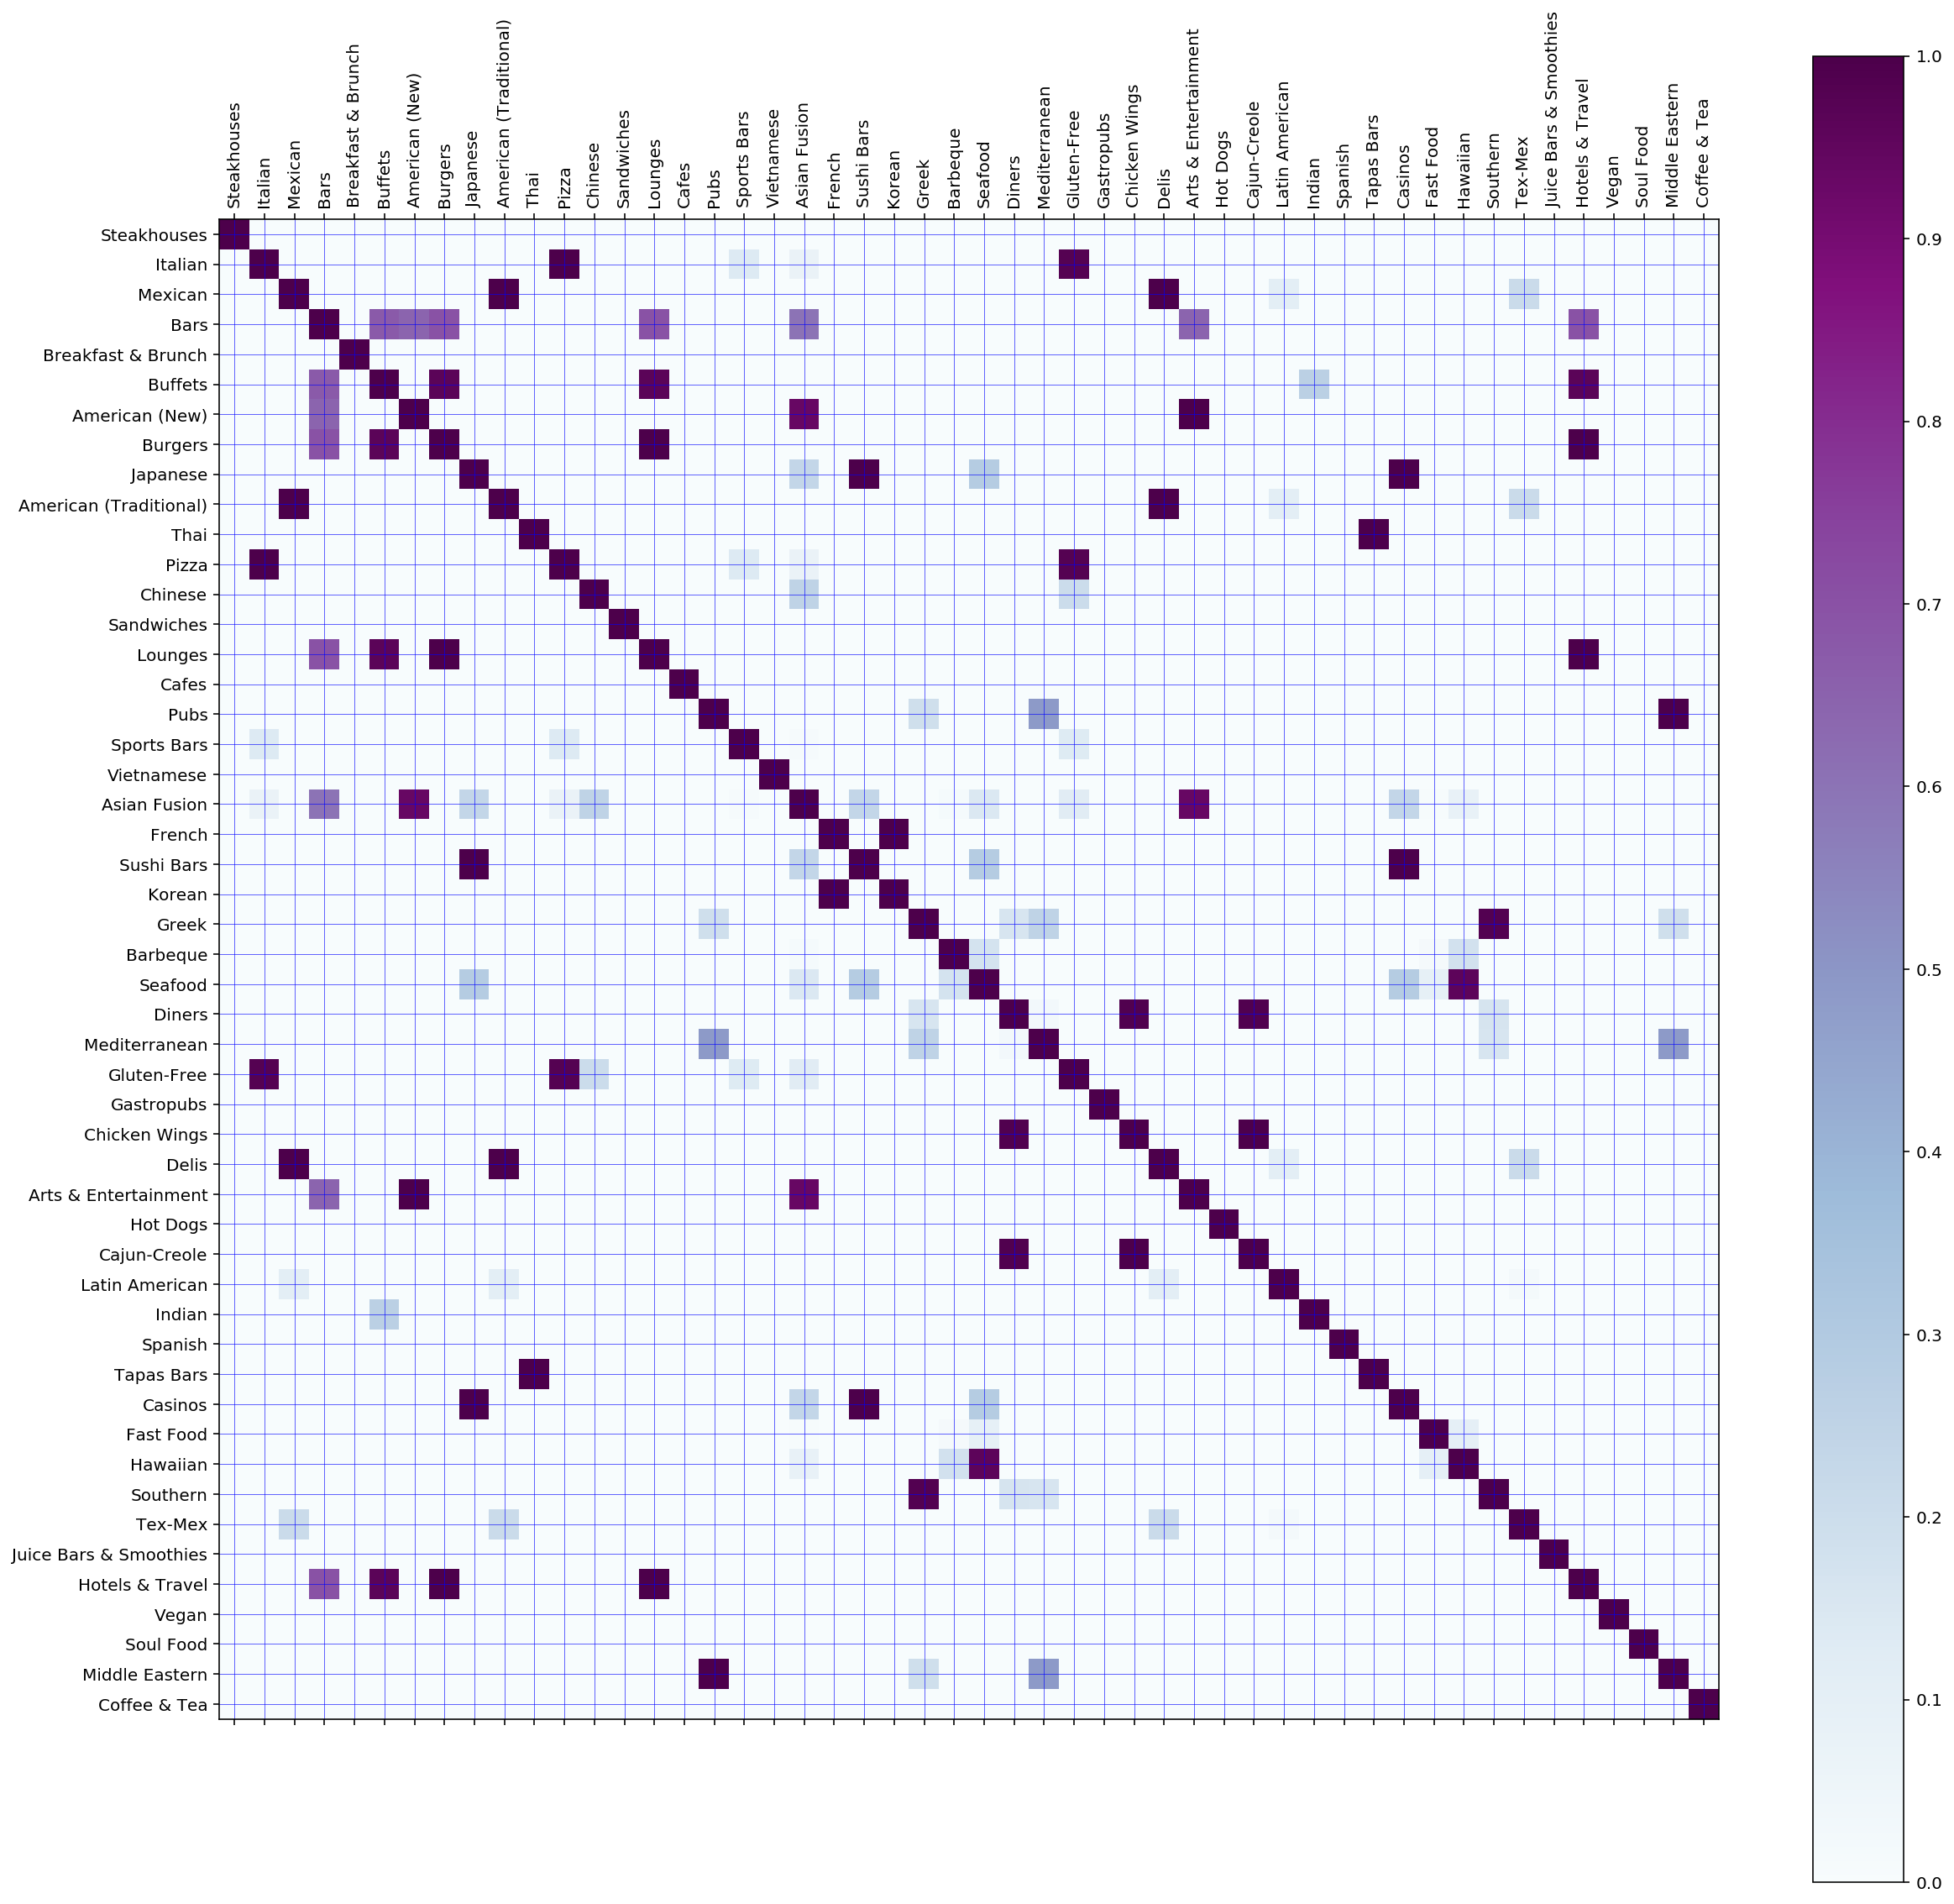

In [9]:
matrix = pd.DataFrame(np.vstack([cosine_similarity(val.reshape(1, -1), topic_pro) for val in topic_pro]))
matrix.columns = cuisines
matrix.index = cuisines
draw(matrix)

In [388]:
%%time
matrix_if, similarity_if, id2words = vectorizer(contents, use_idf=True, min_df=2, max_df=0.5)

CPU times: user 1min 36s, sys: 4.86 s, total: 1min 41s
Wall time: 1min 41s


In [392]:
%%time
corpus = matutils.Sparse2Corpus(matrix_if, documents_columns=False)
lda = models.ldamodel.LdaModel(corpus, 
                                num_topics=100,
                                id2word=id2words,
                                alpha='auto',
                                eval_every=5)
doc_topics = lda.get_document_topics(corpus)

CPU times: user 14 s, sys: 164 ms, total: 14.2 s
Wall time: 2.45 s


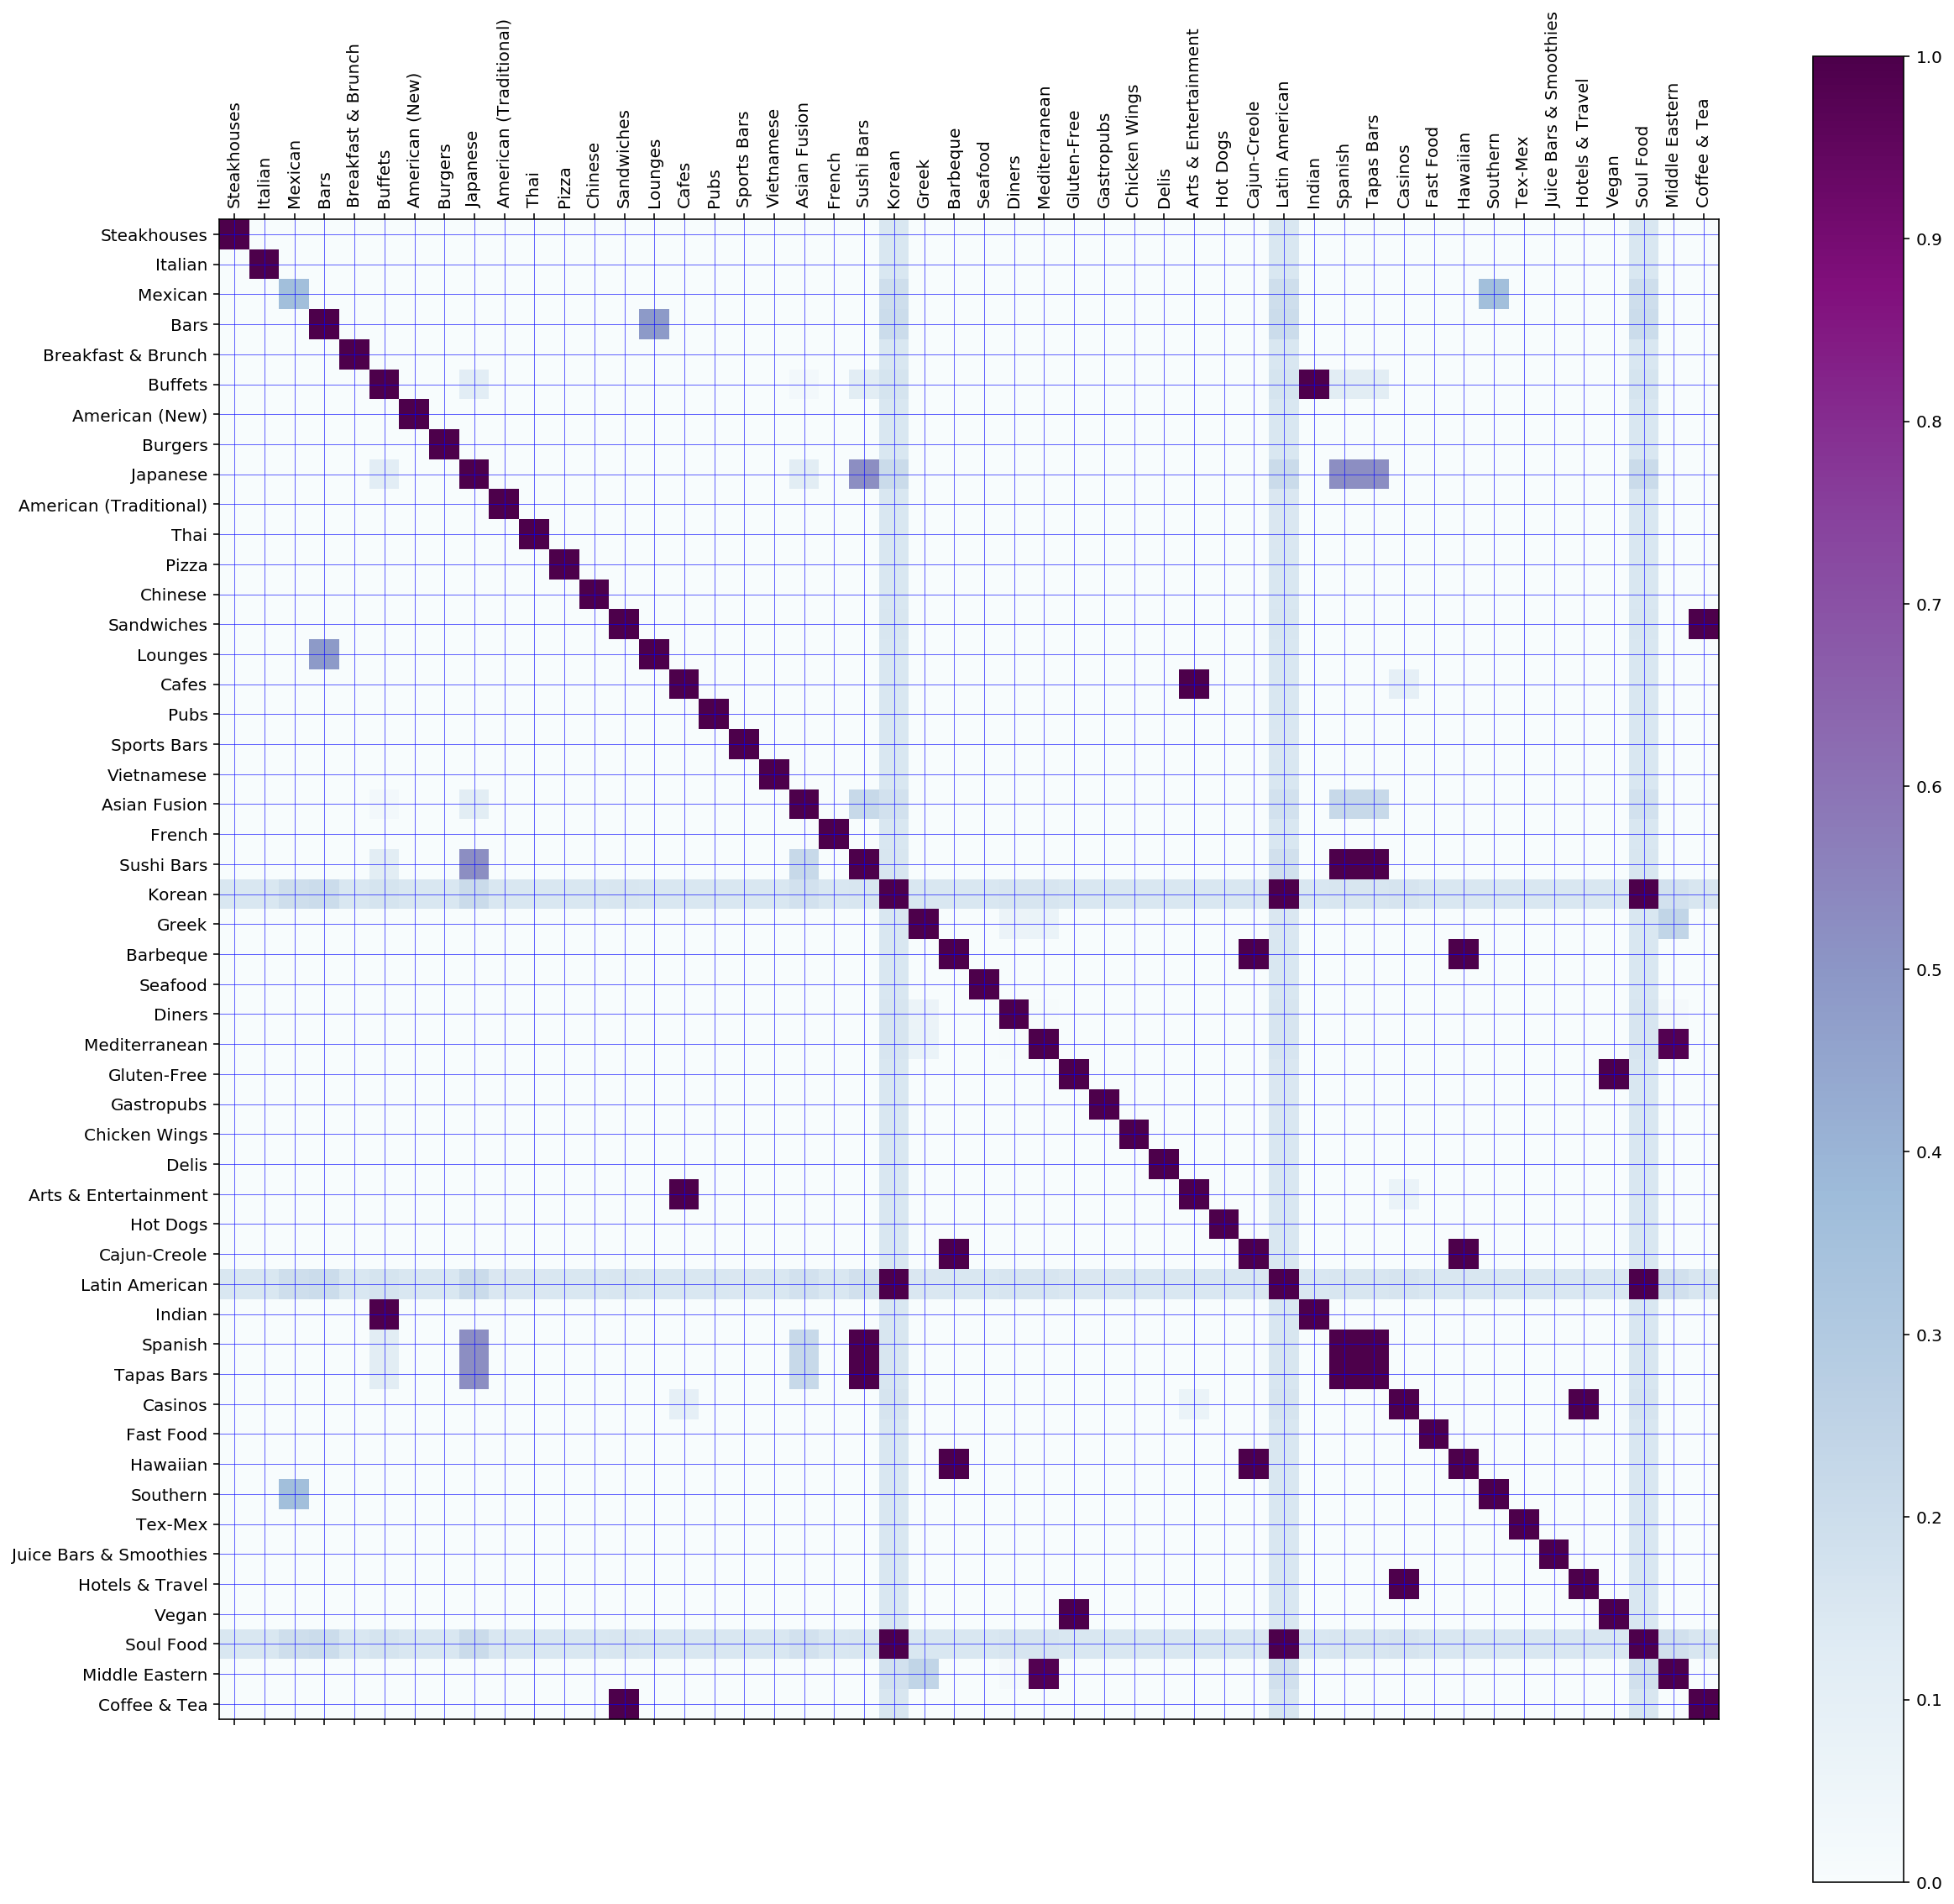

In [394]:
matrix = pd.DataFrame(cuisine_matrix)
matrix.columns = cuisines
matrix.index = cuisines
draw(matrix)

In [393]:
cuisine_matrix = [] #similarity of topics
# computing cosine similarity matrix
for i, doc_a in enumerate(doc_topics):
    #print (i)
    sim_vecs = []
    for j , doc_b in enumerate(doc_topics):
        w_sum = 0
        if ( i <= j ):
            norm_a = 0
            norm_b = 0

            for (my_topic_b, weight_b) in doc_b:
                norm_b = norm_b + weight_b*weight_b

            for (my_topic_a, weight_a) in doc_a:
                norm_a = norm_a + weight_a*weight_a
                for (my_topic_b, weight_b) in doc_b:
                    if ( my_topic_a == my_topic_b ):
                        w_sum = w_sum + weight_a*weight_b

            norm_a = math.sqrt(norm_a)
            norm_b = math.sqrt(norm_b)
            denom = (float) (norm_a * norm_b)
            if denom < 0.0001:
                w_sum = 0
            else:
                w_sum = w_sum/(denom)
        else:
            w_sum = cuisine_matrix[j][i]
        sim_vecs.append(w_sum)

    cuisine_matrix.append(sim_vecs)

## Task 2.3: Incorporating Clustering in Cuisine Map

Use any similarity results from Task 2.1 or Task 2.2 to do clustering. Visualize the clustering results to show the major categories of cuisines. Vary the number of clusters to try at least two very different numbers of clusters, and discuss how this affects the quality or usefulness of the map. Use multiple clustering algorithms for this task. Also note in that each color is a separate cluster in the sample images below.

Tried various clustering methods available via sklearn:
https://scikit-learn.org/stable/modules/clustering.html
* k-means clustering
* agglomerative clustering
* spectral clustering

In [325]:
def plot_mds(model, dist):
    %matplotlib inline
    
    clusters = model.labels_.tolist() 
    c_idx = list(set(clusters)) # list(range(0, len(set(clusters))))
    c_list = ["cluster "+ str(i) for i in c_idx]
    cluster_names = dict(zip(c_idx, c_list))
    
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=cuisines))

    #group by cluster
    groups = df.groupby('label')
    
    # set up plot
    fig, ax = plt.subplots(figsize=(15, 10)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_names[name], color=mcolors.to_hex(cluster_colors[name]),
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')

    ax.legend(numpoints=1)  # show legend with only 1 point

    # add label in x,y position with the label as the film title
    for i in range(len(df)):
        ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)

    plt.show()  # show the plot

In [326]:
def plot_pca(model, X):
    pca = PCA(n_components=2).fit(X)
    pca_2d = pca.transform(X)

    fig, ax = plt.subplots(figsize=(15, 10))

    for i in range(0, pca_2d.shape[0]):
        ax.scatter(pca_2d[i,0],pca_2d[i,1], c=cluster_colors[model.labels_[i]], marker='*')

    for i, txt in enumerate(cuisines):
        ax.annotate(txt, (pca_2d[i,0],pca_2d[i,1]))        

    plt.title('K-Means Clustering')
    plt.show()

### A. KMeans Clustering

In [327]:
mtx = matrix_if1
X = mtx.toarray() # from Task 2.1
dist = 1 - similarity_if1

#### k=5 clusters

In [328]:
%%time
num_clusters = 5
SEED = 123
km5 = KMeans(n_clusters=num_clusters, random_state=SEED).fit(mtx)

CPU times: user 15.3 s, sys: 73.2 ms, total: 15.3 s
Wall time: 2.6 s


/anaconda3/envs/uiuc/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


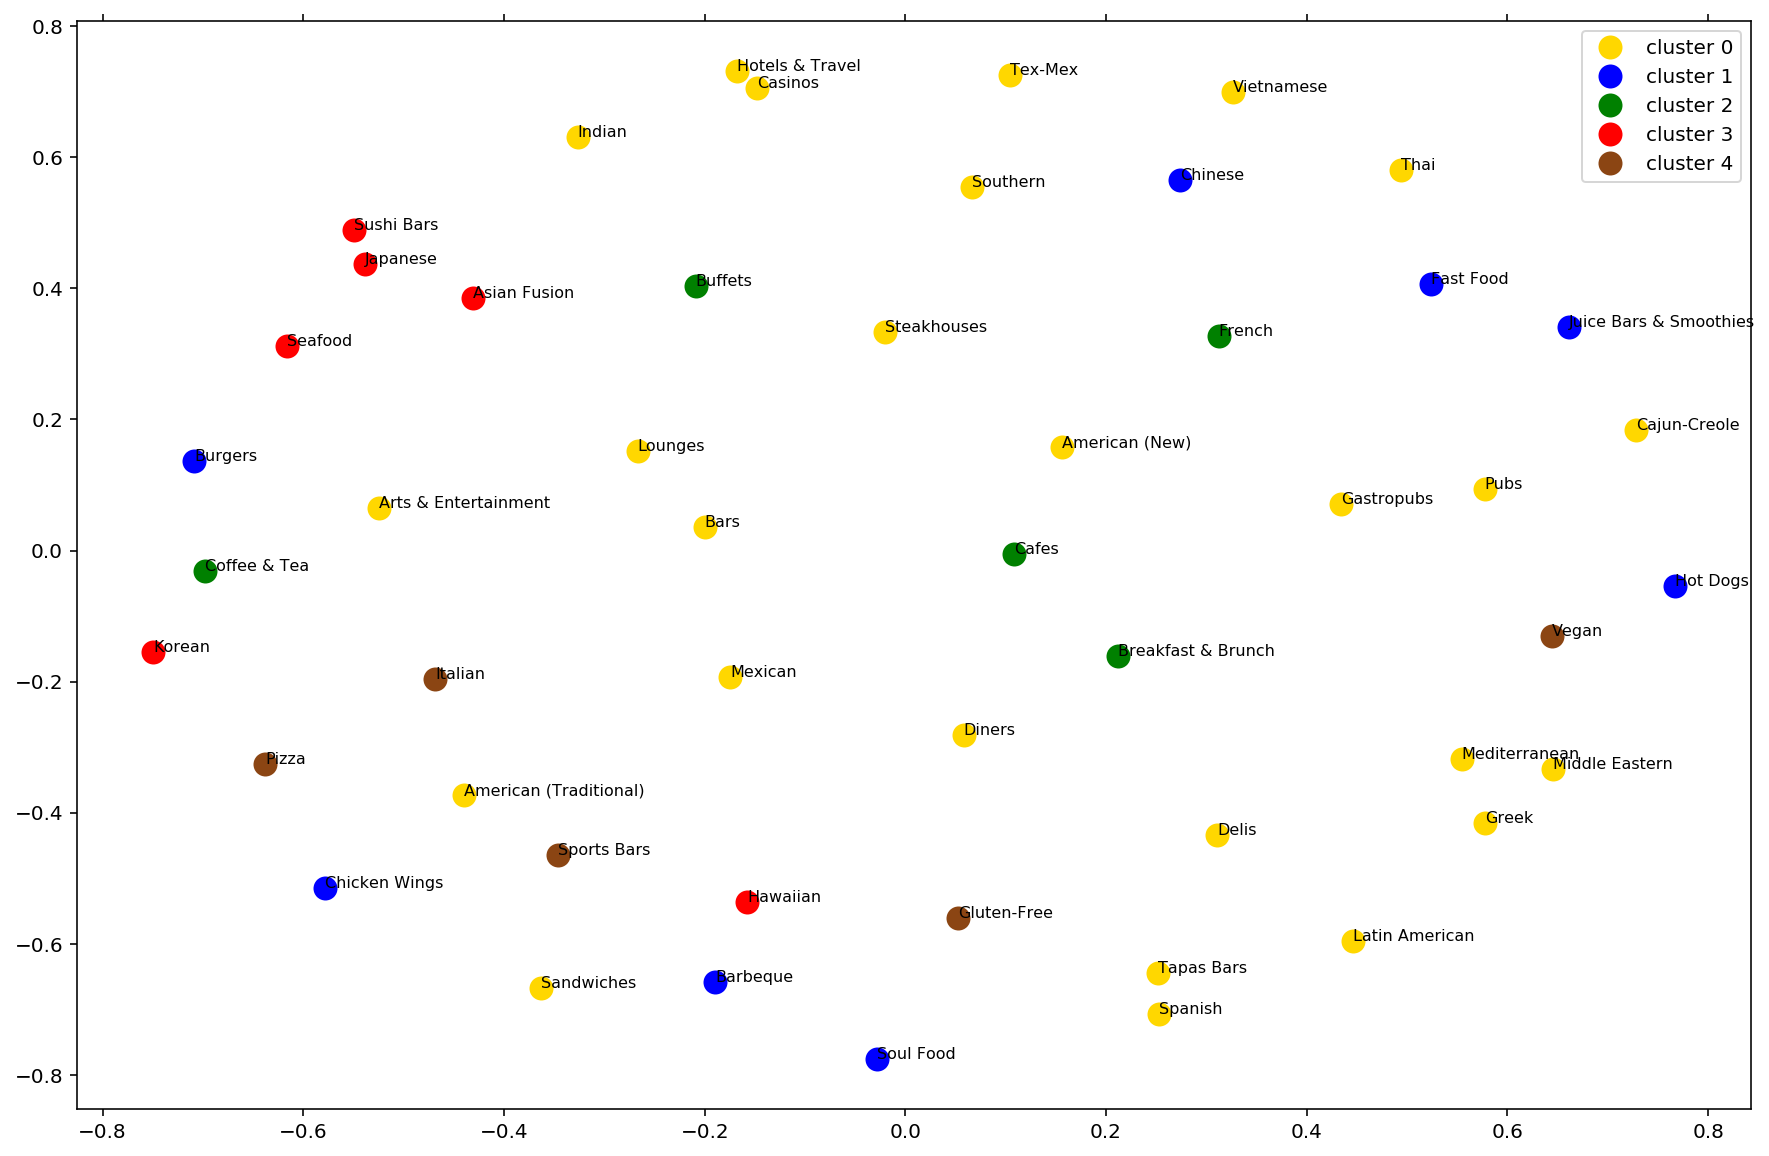

In [329]:
# MDS
plot_mds(km5, dist)

<IPython.core.display.Javascript object>


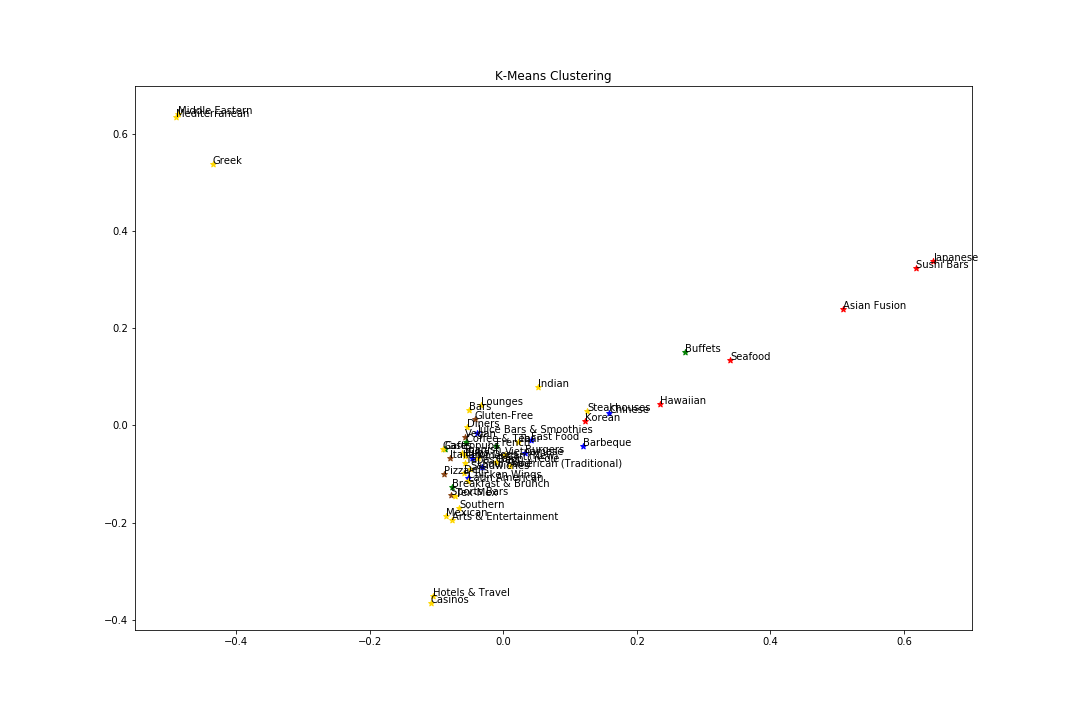

In [334]:
# PCA
%matplotlib notebook
%matplotlib notebook
plot_pca(km5, X)

#### k = 15 clusters

In [335]:
%%time
num_clusters = 15
SEED = 123
km15 = KMeans(n_clusters=num_clusters, random_state=SEED).fit(mtx)

CPU times: user 16.3 s, sys: 88.5 ms, total: 16.4 s
Wall time: 2.82 s


/anaconda3/envs/uiuc/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


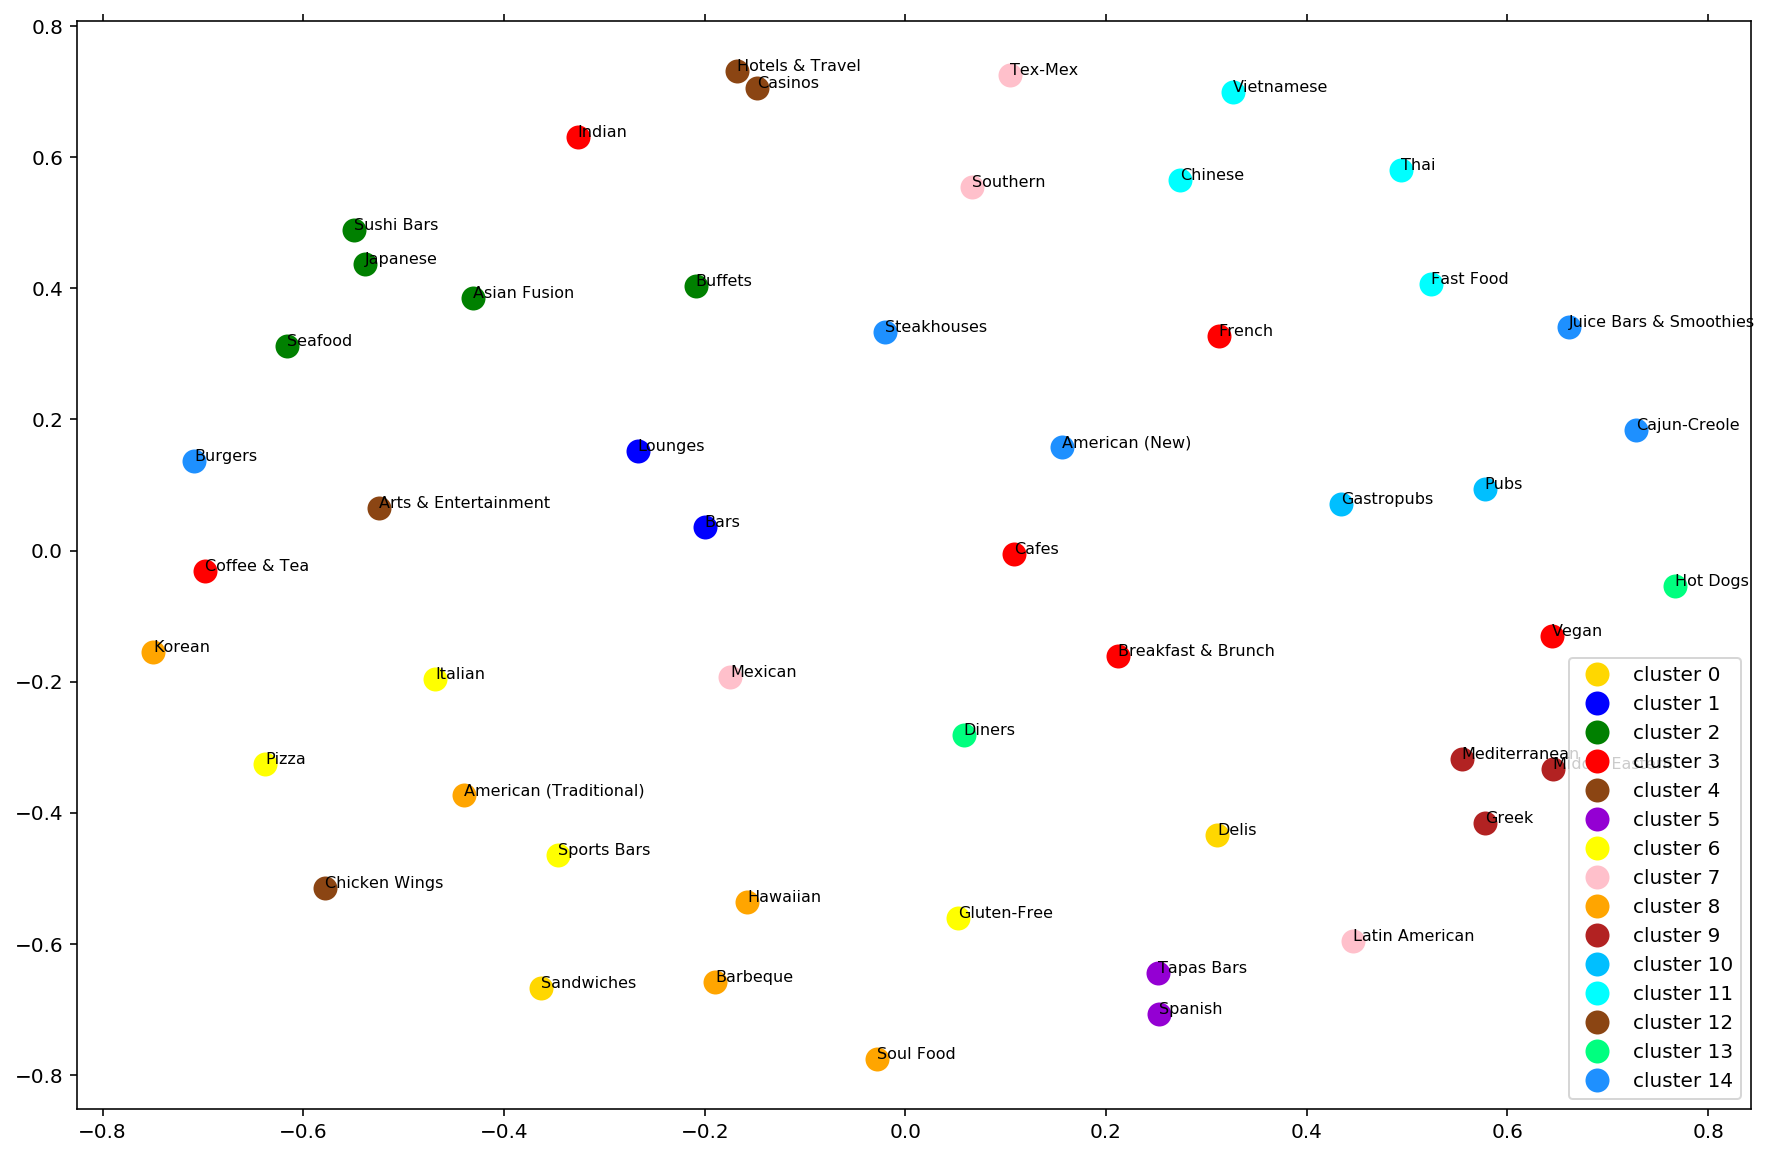

In [336]:
# MDS
plot_mds(km15, dist)

<IPython.core.display.Javascript object>


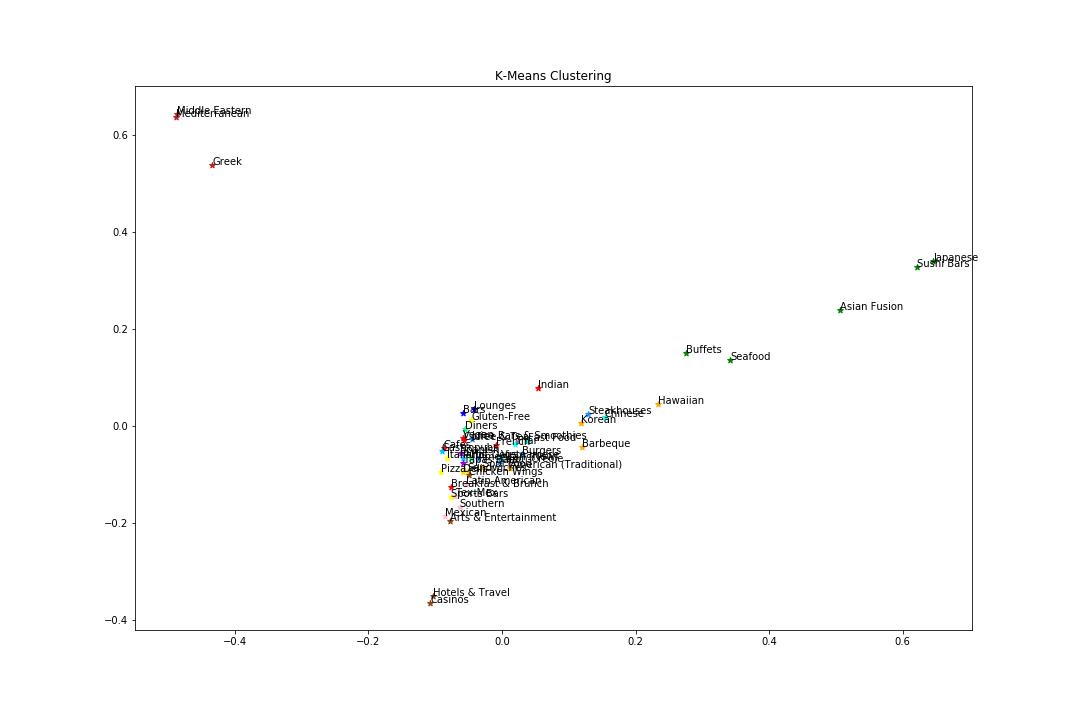

In [337]:
# PCA
%matplotlib notebook
%matplotlib notebook
plot_pca(km15, X)

### B. DBSCAN

In [313]:
dbscan = DBSCAN(eps=1, min_samples=2)
dbscan.fit(X)

/anaconda3/envs/uiuc/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


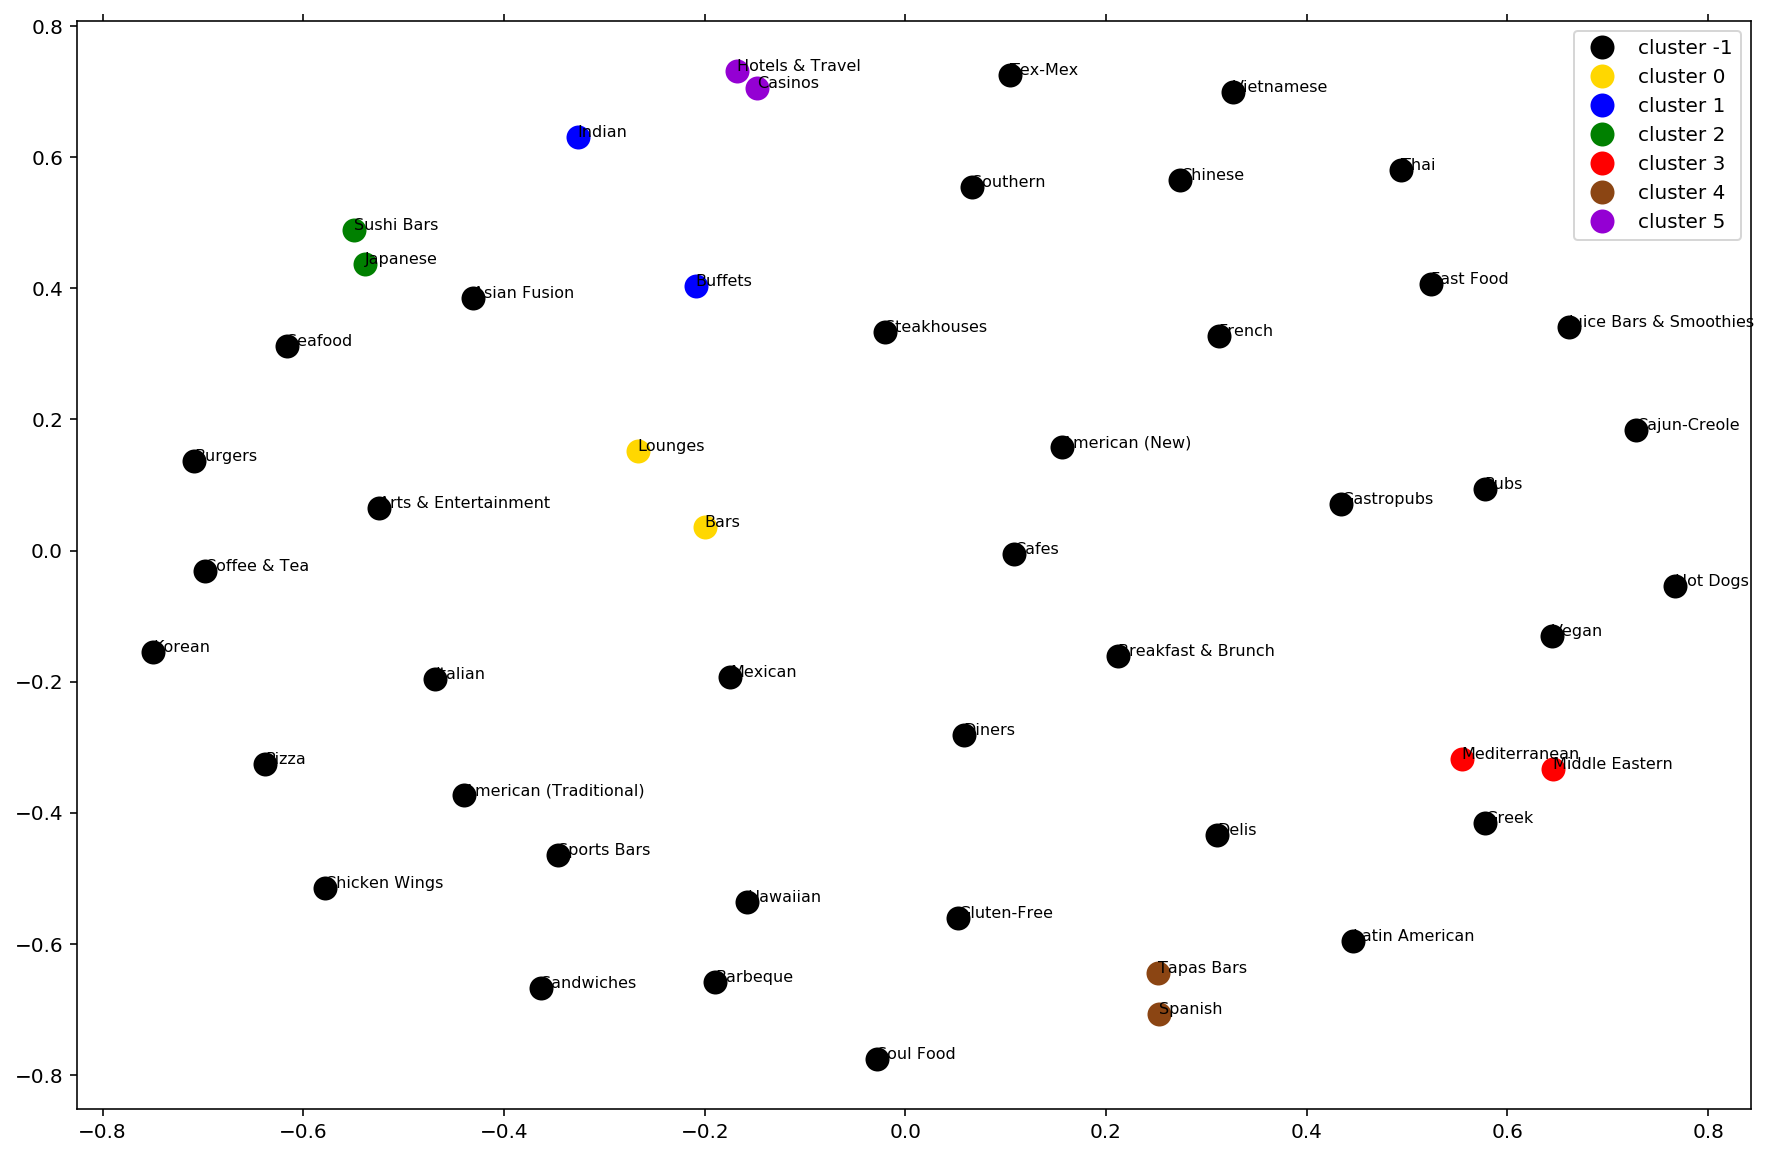

In [338]:
# MDS
plot_mds(dbscan, dist)

<IPython.core.display.Javascript object>


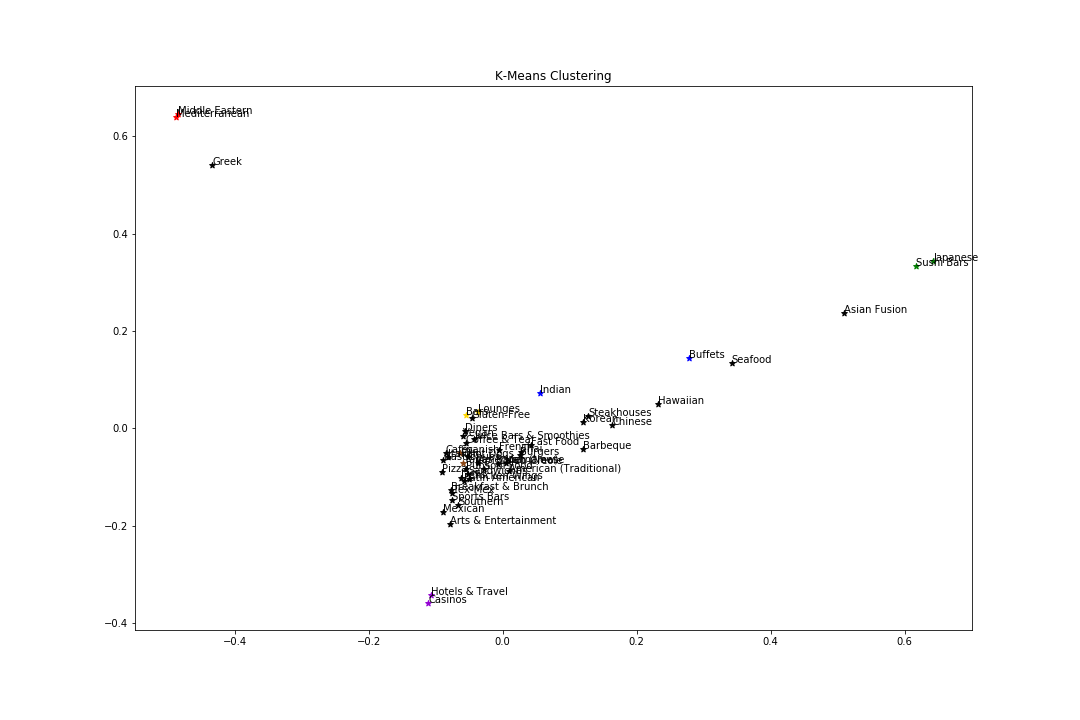

In [339]:
# PCA
%matplotlib notebook
%matplotlib notebook
plot_pca(dbscan, X)

### C1. Agglomerative Clustering (Ward)

In [80]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, SpectralClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

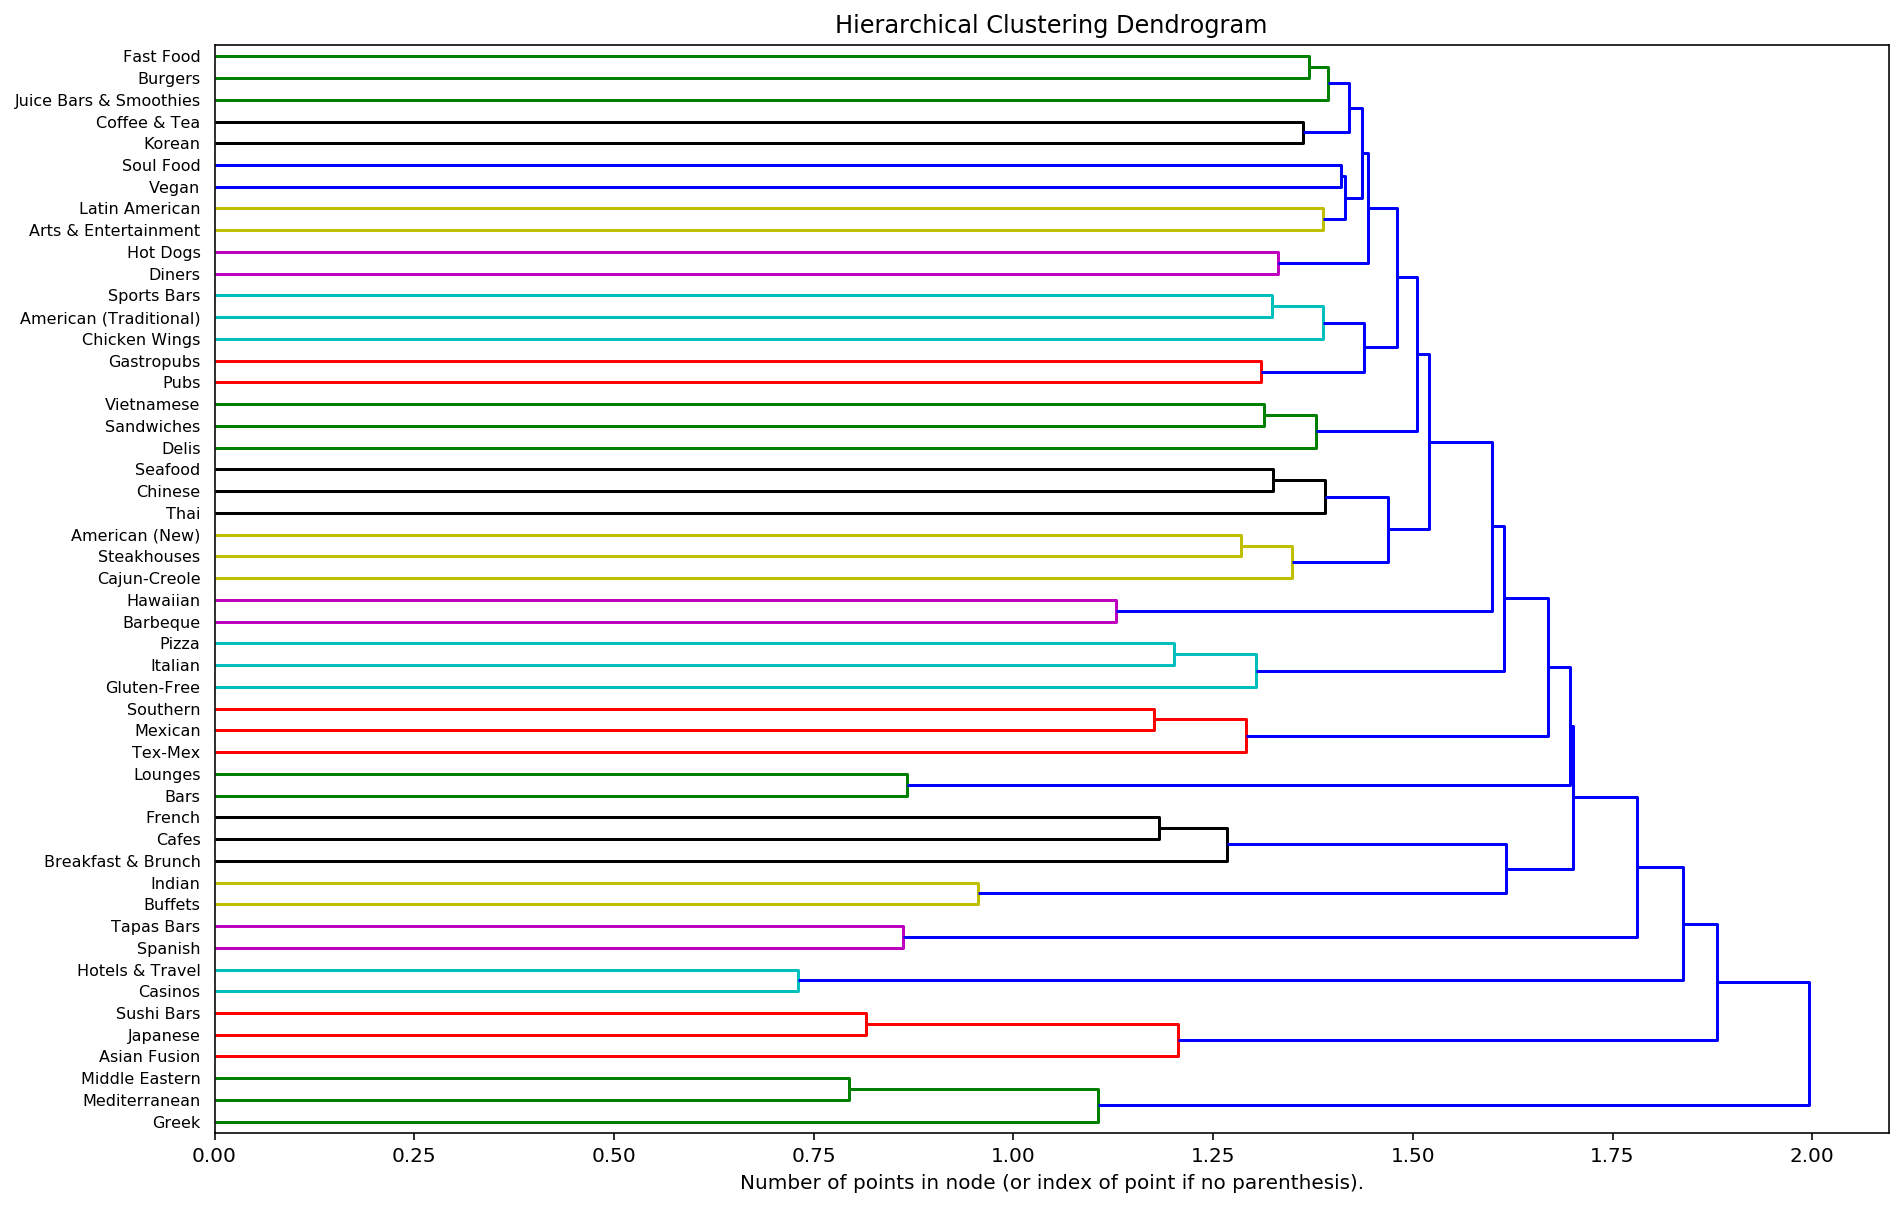

In [88]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="ward")
model = model.fit(X)

plt.figure(figsize=(15, 10))
labelsize=30
ticksize=20
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', labels=matrix.columns, orientation="right")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### C2. Hierarchical Clustering 2

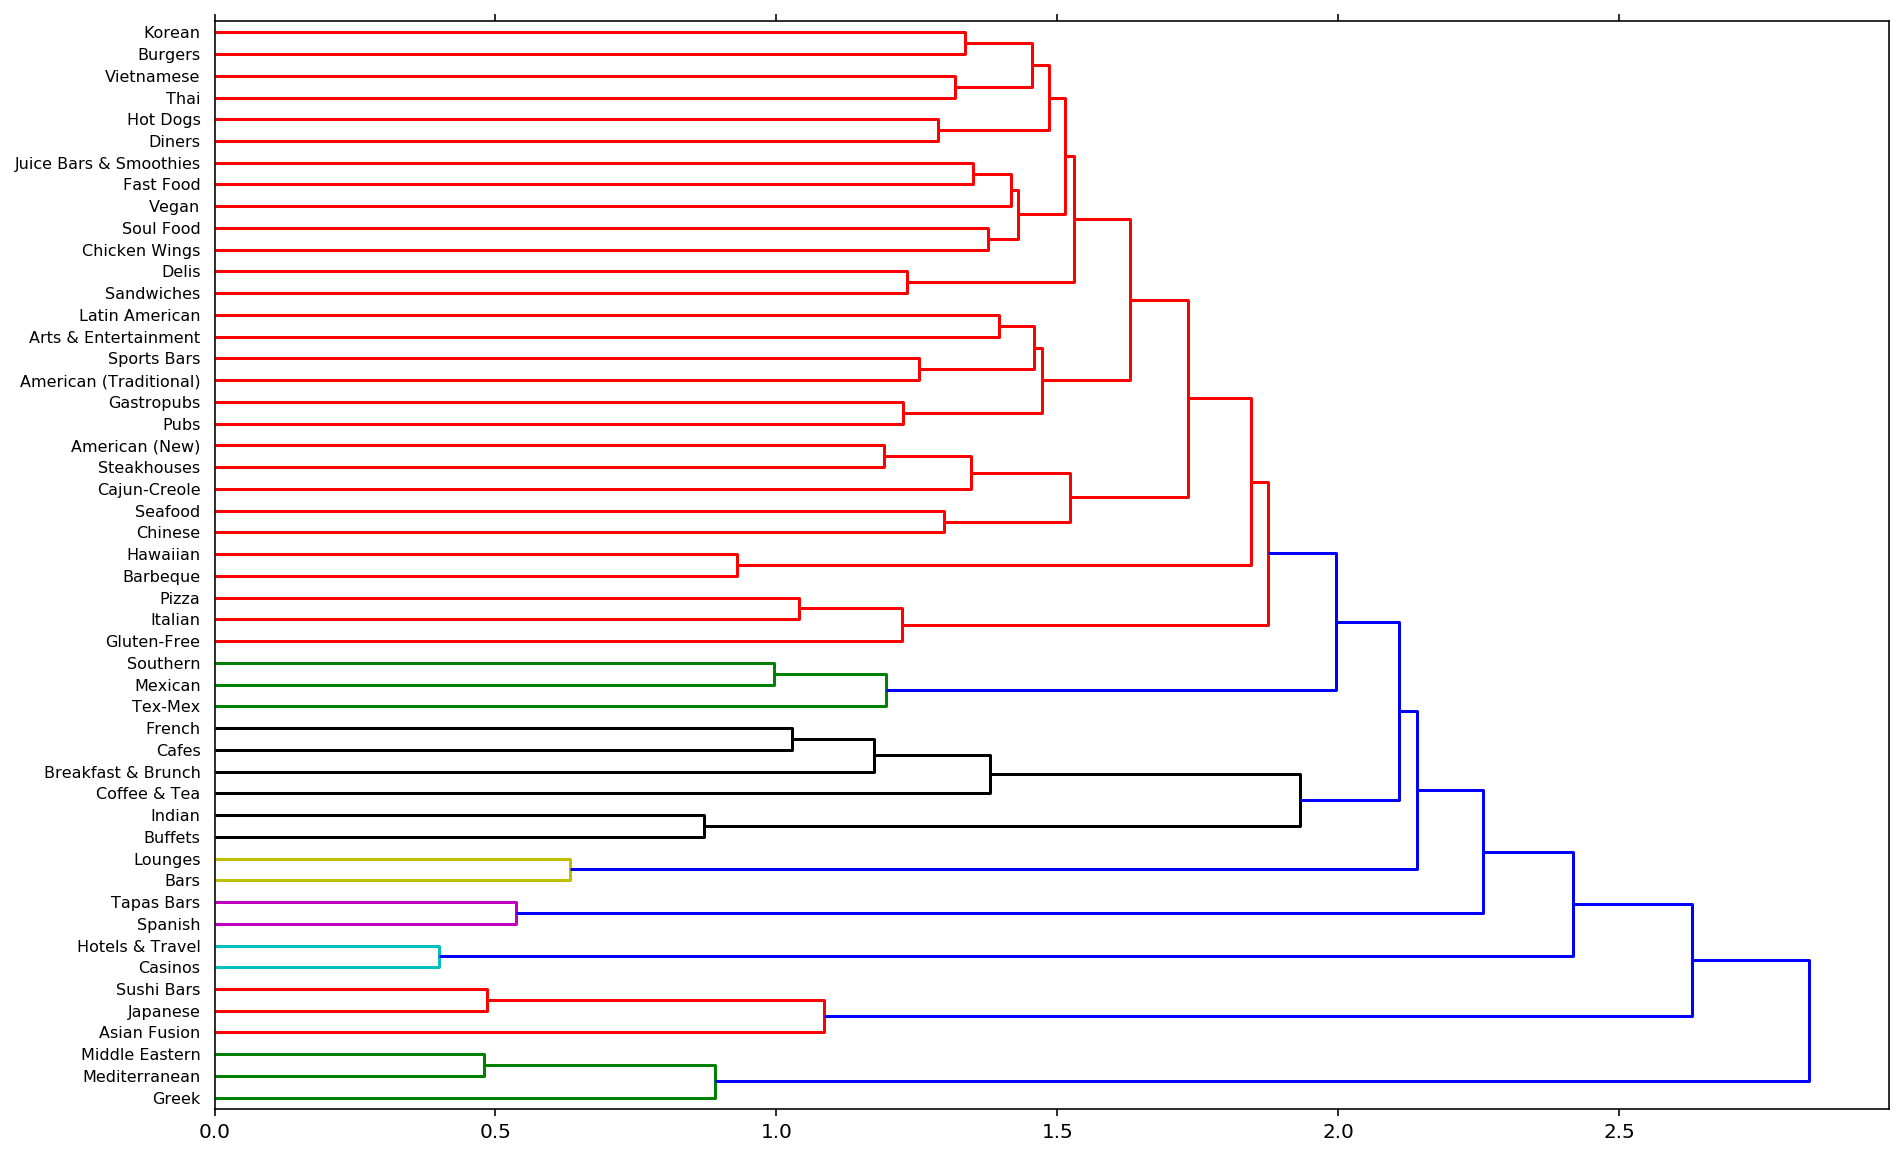

In [89]:
from scipy.cluster.hierarchy import ward, dendrogram

dist = 1 - similarity_if1
linkage_matrix = ward(dist)
fig, ax = plt.subplots(figsize=(15, 10)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=cuisines);

plt.tick_params(
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.show() #show plot with tight layout

### Scratch

In [27]:
# https://matplotlib.org/2.0.0/examples/color/named_colors.html
COLOR = {-1:'black', 0:'gold', 1:'blue', 2:'green', 3:'red', 4:'c', 5:'magenta', 
            6:'yellow', 7:'pink', 8:'orange', 9:'firebrick', 10:'deepskyblue',
            11:'aqua', 12:'saddlebrown', 13:'springgreen', 14:'dodgerblue', 15:'coral',
            16:'mediumslateblue', 17:'magenta', 18:'seagreen', 19:'lightslategrey', 20:'cyan'}
# colors_list = list(mcolors.CSS4_COLORS.keys())
# colors_idx = list(range(-1, len(colors_list)-1))
# COLOR = dict(zip(colors_idx, colors_list))

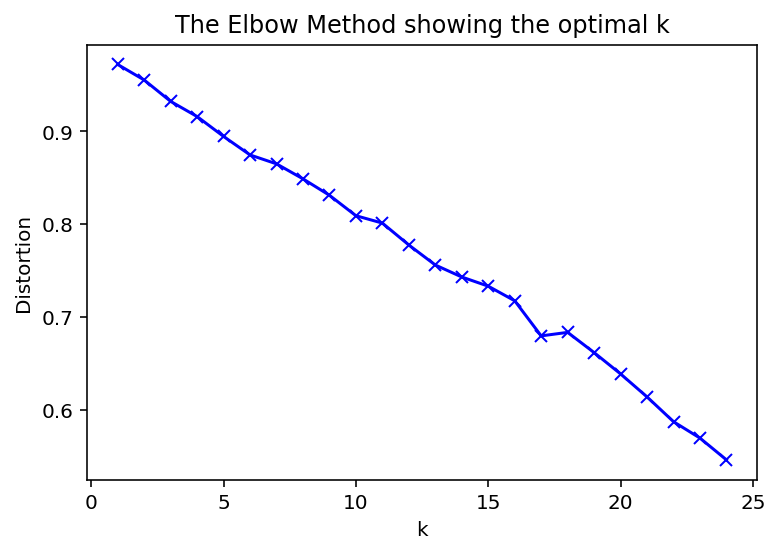

CPU times: user 1min 3s, sys: 573 ms, total: 1min 3s
Wall time: 10.7 s


In [28]:
%%time
# https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
distortions = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## References
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* https://scikit-learn.org/stable/modules/clustering.html
* https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
* https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
* https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html